In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import gensim.downloader as gensim_downloader
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import pickle
import scipy.sparse as sp
import os
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import f1_score
import time
from tqdm import tqdm
import kagglehub
from textblob import TextBlob
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from scipy.sparse import load_npz, save_npz
import random
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download NLTK Required Files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\caner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Introduction

### Problem Definition
In this project, sentiment classification and sentiment analysis will be performed on a dataset consisting of messages from Twitter.

### Dataset
Twitter Emotion Classification Dataset https://www.kaggle.com/datasets/aadyasingh55/twitter-emotion-classification-dataset/data

### 📌 Overview of the Tasks to Be Performed

In this project, sentiment classification will be performed on messages shared on Twitter. The following steps will be followed in sequence:

1. **Data Loading and Inspection**  
   - The general structure of the dataset will be observed
   - Class distribution will be checked
     
2. **Data Cleaning and Preprocessing**  
   - Removal of profanity, URLs, mentions, hashtags, HTML tags, emojis, and special characters  
   - Conversion to lowercase, removal of punctuation marks
   - Stopword removal and lemmatization/stemming processes

3. **Exploratory Data Analysis (EDA)**  
   - Examination of class imbalances  
   - Word clouds, length analysis, most frequent words

4. **Feature Extraction**  
   - TF-IDF vectors
   - Word2Vec
   - (Applied for ML models)

5. **Data Balancing**  
   - Balancing imbalanced classes with undersampling

6. **Modeling and Performance Evaluation**  
   - 📌 **Used Baseline ML Models:** Decision Tree, Logistic Regression, Random Forest, Knn, Naive Bayes, XGBoost  
   - 🤖 **Used Transformer Models:** BERT
   - Accuracy, F1-Score, Confusion Matrix 

## 1. Data Loading and Inspection

In [55]:
df = pd.read_parquet("train-00000-of-00001.parquet")
# df = kagglehub.dataset_download("aadyasingh55/twitter-emotion-classification-dataset")

print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (416809, 2)
                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2


In [4]:
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB
None


In [5]:
print(df.describe(include='all'))

                                                 text          label
count                                          416809  416809.000000
unique                                         393822            NaN
top     i feel more adventurous willing to take risks            NaN
freq                                               16            NaN
mean                                              NaN       1.554271
std                                               NaN       1.490453
min                                               NaN       0.000000
25%                                               NaN       0.000000
50%                                               NaN       1.000000
75%                                               NaN       3.000000
max                                               NaN       5.000000


In [6]:
print("\nNumber of Null:")
print(df.isnull().sum())


Number of Null:
text     0
label    0
dtype: int64


In [7]:
# I visualized the class distribution in the data analysis section and provided an interpretation.
print("\nDistribution of emotion classes:")
print(df['label'].value_counts())
print((df['label'].value_counts(normalize=True) * 100).round(2).astype(str) + "%")


Distribution of emotion classes:
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: label, dtype: int64
1    33.84%
0    29.07%
3    13.75%
4    11.45%
2     8.29%
5     3.59%
Name: label, dtype: object


# 2. Data Cleaning and Preprocessing

In [56]:
def clean_text(text):
    # Function to perform basic cleaning of a Twitter message

    # Convert to lowercase
    text = text.lower()

    # Remove URLs (starting with http, https, www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove usernames (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation marks
    text = re.sub(f'[{string.punctuation}]', '', text)

    # Remove emojis (Unicode emoji ranges)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # chess symbols
                               u"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [57]:
def remove_stopwords(text):
    # Function to remove English stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [58]:
def lemmatize_text(metin):
    # The function finds word lemmas (Lemmatization)
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(metin)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [59]:
def stem_text(metin):
    # The function finds word lemmasr (Stemming)
    stemmer = PorterStemmer()
    tokens = word_tokenize(metin)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

In [60]:
# Displayed the raw and cleaned versions of the first 5 tweets
print("\nRaw and Cleaned Tweet Examples:")
for i in range(5):
    print(f"Original Tweet {i+1}: {df['text'].iloc[i]}")
    print(f"Cleaned Tweet {i+1}: {clean_text(df['text'].iloc[i])}")
    print("-" * 50)



Raw and Cleaned Tweet Examples:
Original Tweet 1: i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
Cleaned Tweet 1: i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
--------------------------------------------------
Original Tweet 2: im alone i feel awful
Cleaned Tweet 2: im alone i feel awful
--------------------------------------------------
Original Tweet 3: ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals
Cleaned Tweet 3: ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals
--------------------------------------------------
Original Tweet 4: i was feeling a little low few days back
Cleaned Tweet 4: i was feeling a little low few days back
----------------

It can't be said that the dataset is very messy, because when I looked at other data, there wasn't much difference. However, I noticed that some words were misspelled, so I decided to apply spell checking to correct them.

In [61]:
sample_size = len(df)
df_sample = df.head(sample_size).copy()

In [62]:
# I applied the outlier removal process using the IQR method here.
df_sample['text_length'] = df_sample['text'].apply(len)

Q1 = df_sample['text_length'].quantile(0.25)
Q3 = df_sample['text_length'].quantile(0.75)
IQR = Q3 - Q1

before_filtered = len(df_sample)
df_sample = df_sample[(df_sample['text_length'] >= (Q1 - 1.5 * IQR)) & 
                 (df_sample['text_length'] <= (Q3 + 1.5 * IQR))]

print(f"Number of outliers removed: {before_filtered - len(df_sample)}")

Number of outliers removed: 9962


In [63]:
df_sample = df_sample.drop(columns=['text_length'])

In [64]:
# I tried this process to correct misspelled words, but applying it to the entire dataset is time-consuming and it hasn't finished yet.
# Therefore, I applied it to the first 10 records as an example just to see the result.
from textblob import TextBlob

def correct_spelling(text):
    try:
        return str(TextBlob(text).correct())
    except:
        return text

df_sample.loc[:9, 'corrected_text'] = df_sample.loc[:9, 'text'].apply(correct_spelling)

df_sample.head(10)[['text', 'corrected_text']]

,text,corrected_text
0,i feel awful about it too because it s my job ...,i feel awful about it too because it s my job ...
1,im alone i feel awful,in alone i feel awful
2,ive probably mentioned this before but i reall...,give probably mentioned this before but i real...
3,i was feeling a little low few days back,i was feeling a little low few days back
4,i beleive that i am much more sensitive to oth...,i believe that i am much more sensitive to oth...
5,i find myself frustrated with christians becau...,i find myself frustrated with christians becau...
6,i am one of those people who feels like going ...,i am one of those people who feels like going ...
7,i feel especially pleased about this as this h...,i feel especially pleased about this as this h...
8,i was struggling with these awful feelings and...,i was struggling with these awful feelings and...
9,i feel so enraged but helpless at the same time,i feel so enraged but helpless at the same time


In [65]:
df_sample = df_sample.drop(columns=['corrected_text'])

In [66]:
# Basic cleaning process was applied to the entire dataset.
df_sample['clean_text'] = df_sample['text'].apply(clean_text)

In [67]:
# Stopword removal process was applied.
df_sample['remove_stopwords'] = df_sample['clean_text'].apply(remove_stopwords)

In [68]:
# Lemmatization process was applied.
df_sample['lemmatized_text'] = df_sample['remove_stopwords'].apply(lemmatize_text)

In [69]:
# Stemming can cause significant information loss, which is why lemmatization is generally preferred.
# However, I felt the need to add it for comparison.
df_sample['stemmed_text'] = df_sample['remove_stopwords'].apply(stem_text)

# 3.Exploratory Data Analysis (EDA)

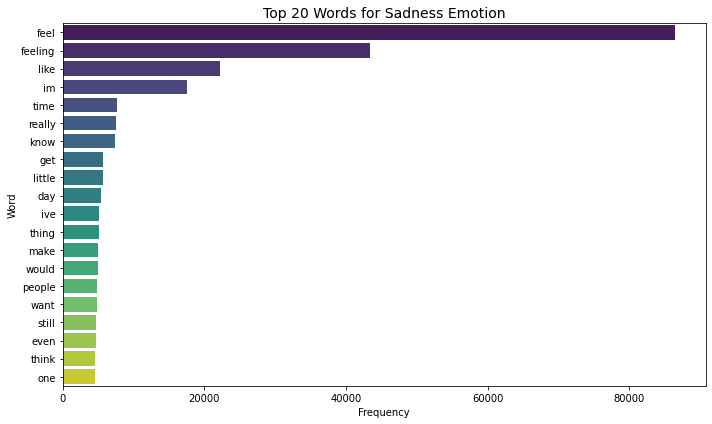

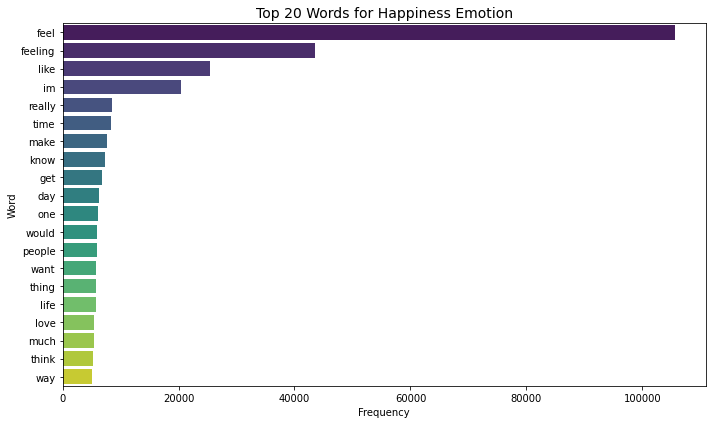

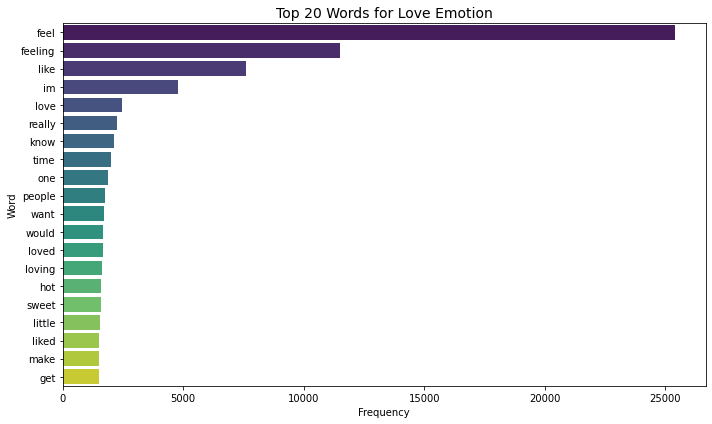

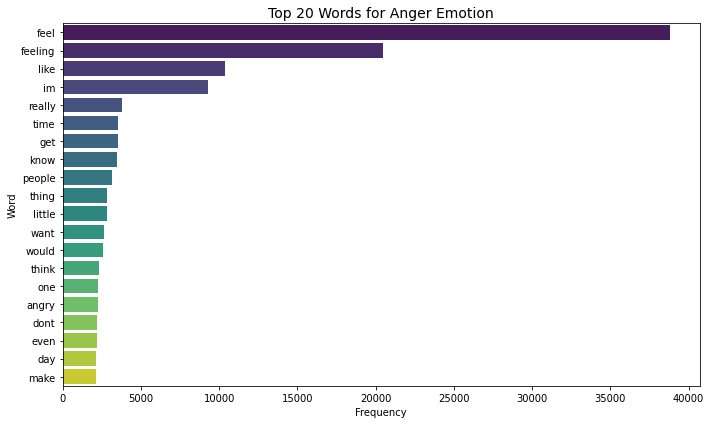

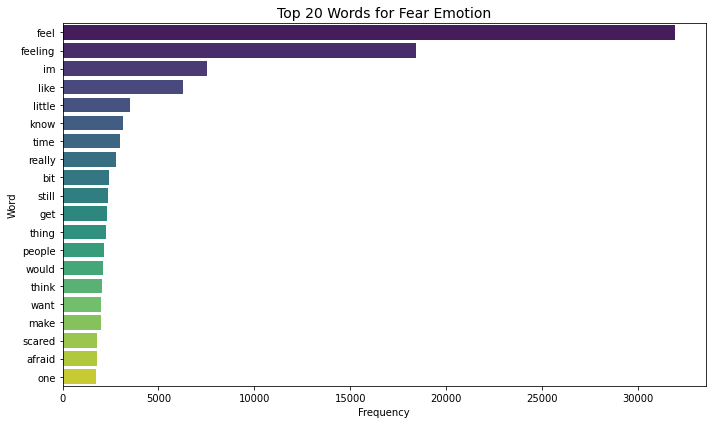

In [41]:
label_map = {0: 'Sadness', 1: 'Happiness', 2: 'Love', 3: 'Anger', 4: 'Fear'}

# Here, I displayed the top 20 most frequent words for each emotion on a graph
for label, emotion_name in label_map.items():
    emotion_texts = df_sample[df_sample['label'] == label]['lemmatized_text']
    
    if len(emotion_texts) > 0:
        all_words = ' '.join(emotion_texts).split()
        word_counts = Counter(all_words).most_common(20)
        words, counts = zip(*word_counts)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(counts), y=list(words), palette="viridis")
        plt.title(f"Top 20 Words for {emotion_name} Emotion", fontsize=14)
        plt.xlabel("Frequency")
        plt.ylabel("Word")
        plt.tight_layout()
        plt.show()


**Comment**: When I examined the top 20 most frequently used words for each emotion class, I observed that some words, like 'feel,' are commonly used with high frequency across all emotion categories. This indicates that people tend to use the same basic words when expressing their emotions. This situation highlighted the difficulty of distinguishing emotions by simply looking at the most frequently used words. Therefore, I decided to perform a more detailed analysis to identify words that are used significantly more in one emotion class compared to the others.


Emotion-specific words (occurring less in other classes but frequently in this class):

Words specific to Sadness emotion:
doomed: 1305 occurrences (about 118.64 times more frequent compared to other emotions)
remorseful: 687 occurrences (about 98.14 times more frequent compared to other emotions)
unwelcome: 1200 occurrences (about 85.71 times more frequent compared to other emotions)
unimportant: 1268 occurrences (about 79.25 times more frequent compared to other emotions)
listless: 880 occurrences (about 73.33 times more frequent compared to other emotions)
neglectful: 433 occurrences (about 72.17 times more frequent compared to other emotions)
victimized: 671 occurrences (about 61.00 times more frequent compared to other emotions)
groggy: 1329 occurrences (about 60.41 times more frequent compared to other emotions)
defective: 347 occurrences (about 57.83 times more frequent compared to other emotions)
disheartened: 1190 occurrences (about 51.74 times more frequent compared to other

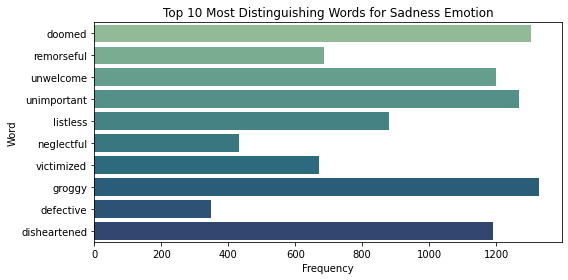


Words specific to Happiness emotion:
invigorated: 1279 occurrences (about 142.11 times more frequent compared to other emotions)
honoured: 1110 occurrences (about 123.33 times more frequent compared to other emotions)
bouncy: 546 occurrences (about 109.20 times more frequent compared to other emotions)
virtuous: 1075 occurrences (about 107.50 times more frequent compared to other emotions)
terrific: 958 occurrences (about 106.44 times more frequent compared to other emotions)
tranquil: 312 occurrences (about 104.00 times more frequent compared to other emotions)
triumphant: 860 occurrences (about 95.56 times more frequent compared to other emotions)
sociable: 613 occurrences (about 76.62 times more frequent compared to other emotions)
glamorous: 706 occurrences (about 70.60 times more frequent compared to other emotions)
jolly: 587 occurrences (about 65.22 times more frequent compared to other emotions)


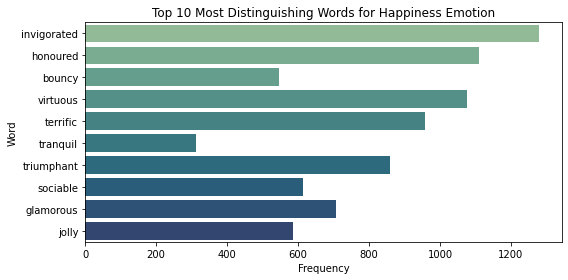


Words specific to Love emotion:
horny: 1148 occurrences (about 42.52 times more frequent compared to other emotions)
slutty: 378 occurrences (about 34.36 times more frequent compared to other emotions)
sympathetic: 1424 occurrences (about 27.92 times more frequent compared to other emotions)
naughty: 1174 occurrences (about 20.60 times more frequent compared to other emotions)
affectionate: 522 occurrences (about 20.08 times more frequent compared to other emotions)
amorous: 139 occurrences (about 19.86 times more frequent compared to other emotions)
loyal: 997 occurrences (about 19.55 times more frequent compared to other emotions)
delicate: 1050 occurrences (about 18.42 times more frequent compared to other emotions)
tender: 1393 occurrences (about 16.78 times more frequent compared to other emotions)
devoted: 568 occurrences (about 15.35 times more frequent compared to other emotions)


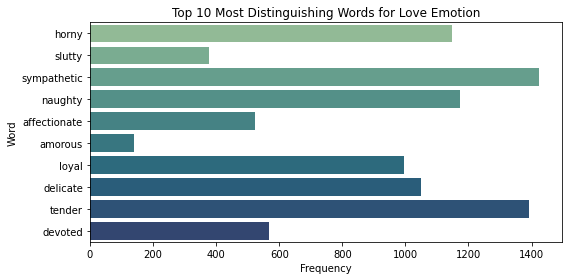


Words specific to Anger emotion:
wronged: 1347 occurrences (about 58.57 times more frequent compared to other emotions)
greedy: 1321 occurrences (about 50.81 times more frequent compared to other emotions)
irate: 153 occurrences (about 38.25 times more frequent compared to other emotions)
dissatisfied: 1352 occurrences (about 36.54 times more frequent compared to other emotions)
rebellious: 1046 occurrences (about 36.07 times more frequent compared to other emotions)
outraged: 533 occurrences (about 31.35 times more frequent compared to other emotions)
impolite: 91 occurrences (about 30.33 times more frequent compared to other emotions)
infuriated: 144 occurrences (about 28.80 times more frequent compared to other emotions)
aggravated: 514 occurrences (about 28.56 times more frequent compared to other emotions)
bitchy: 1393 occurrences (about 28.43 times more frequent compared to other emotions)


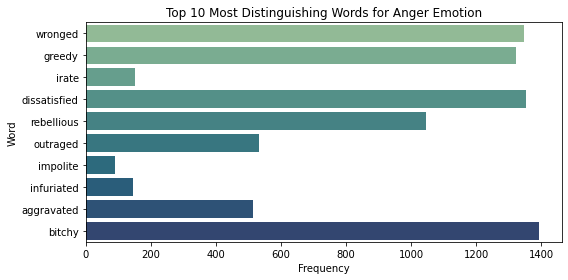


Words specific to Fear emotion:
uptight: 570 occurrences (about 40.71 times more frequent compared to other emotions)
wimpy: 266 occurrences (about 38.00 times more frequent compared to other emotions)
bashful: 189 occurrences (about 37.80 times more frequent compared to other emotions)
frantic: 899 occurrences (about 34.58 times more frequent compared to other emotions)
apprehensive: 1374 occurrences (about 34.35 times more frequent compared to other emotions)
shaken: 1196 occurrences (about 33.22 times more frequent compared to other emotions)
hesitant: 1353 occurrences (about 30.07 times more frequent compared to other emotions)
startled: 177 occurrences (about 29.50 times more frequent compared to other emotions)
reluctant: 1382 occurrences (about 29.40 times more frequent compared to other emotions)
distressed: 906 occurrences (about 29.23 times more frequent compared to other emotions)


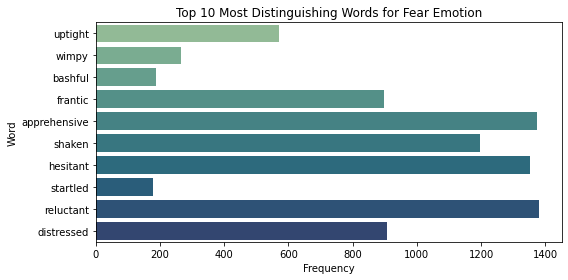

In [42]:
label_map = {0: 'Sadness', 1: 'Happiness', 2: 'Love', 3: 'Anger', 4: 'Fear'}

# Trying to find the most distinguishing words for each emotion class
print("\nEmotion-specific words (occurring less in other classes but frequently in this class):")

for emotion in range(5):
    emotion_name = label_map[emotion]
    
    this_emotion = ' '.join(df_sample[df_sample['label'] == emotion]['lemmatized_text'])
    other_emotions = ' '.join(df_sample[df_sample['label'] != emotion]['lemmatized_text'])
    
    this_emotion_words = Counter(this_emotion.split())
    other_emotions_words = Counter(other_emotions.split())
    
    unique_words = []
    
    for word, count in this_emotion_words.items():
        if word in other_emotions_words and other_emotions_words[word] > 0:
            ratio = count / (other_emotions_words[word] + 1)
            if ratio > 2 and count > 5:
                unique_words.append((word, ratio, count))
    
    unique_words.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nWords specific to {emotion_name} emotion:")
    for word, ratio, count in unique_words[:10]:
        print(f"{word}: {count} occurrences (about {ratio:.2f} times more frequent compared to other emotions)")
    
    # Plotting section
    if unique_words:
        words = [w[0] for w in unique_words[:10]]
        frequencies = [w[2] for w in unique_words[:10]]

        plt.figure(figsize=(8, 4))
        sns.barplot(x=frequencies, y=words, palette="crest")
        plt.title(f"Top 10 Most Distinguishing Words for {emotion_name} Emotion")
        plt.xlabel("Frequency")
        plt.ylabel("Word")
        plt.tight_layout()
        plt.show()


**Comment:** This analysis shows the characteristic words specific to each sentiment class and their usage frequencies. Distinct word patterns stand out in each sentiment category: negative words like "doomed" and "remorseful" in the sadness sentiment; positive words like "invigorated" and "terrific" in the happiness sentiment; romantic/sexual words like "horny" and "affectionate" in the love sentiment; anger-indicating words like "wronged" and "irate" in the anger sentiment; and anxiety/panic expressions like "uptight" and "frantic" in the fear sentiment. This word distribution clearly shows the linguistic features of sentiment expressions on Twitter and helps us identify which word patterns the model should pay attention to when performing sentiment detection. Using these findings, I can create more effective representations during the feature engineering phase.

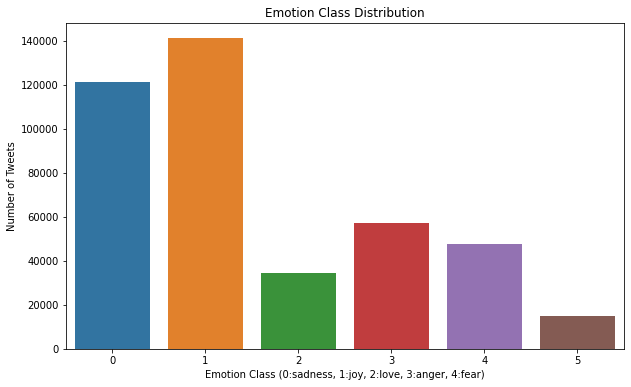

In [43]:
# Class distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion Class (0:sadness, 1:joy, 2:love, 3:anger, 4:fear)')
plt.ylabel('Number of Tweets')
plt.savefig('emotion_distribution.png')
plt.show()

**Comment:** This graph showing the distribution of emotion classes indicates a significant imbalance in the dataset. The emotions of happiness (1) and sadness (0) contain many more tweets compared to the other emotions, while love (2) and surprise (5) are less represented. This imbalance may cause the classification model to be biased towards certain emotions. Therefore, in future stages, I will use SMOTE or undersampling to address this imbalance.


Tweet length statistics:
count    416809.000000
mean         97.028397
std          56.198232
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text_length, dtype: float64


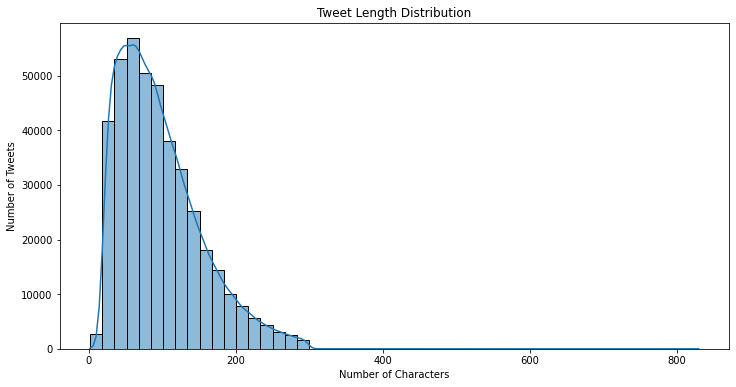

In [44]:
# Tweet length analysis
df['text_length'] = df['text'].apply(len)
print("\nTweet length statistics:")
print(df['text_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Tweets')
plt.show()


**Comment:** This graph showing the distribution of tweet lengths reveals a right-skewed distribution of the data. Most tweets are concentrated in the 50-150 character range, with the highest frequency around 80-100 characters, with approximately 55,000 tweets. The number of tweets longer than 200 characters rapidly decreases, and tweets longer than 400 characters are quite rare. This distribution indicates that users typically write short and concise messages, in line with Twitter's short message format, but in some cases, longer content is also shared. By applying the IQR method during the data preprocessing phase to clean outliers in this distribution, I will ensure that my model is trained with more consistent data.

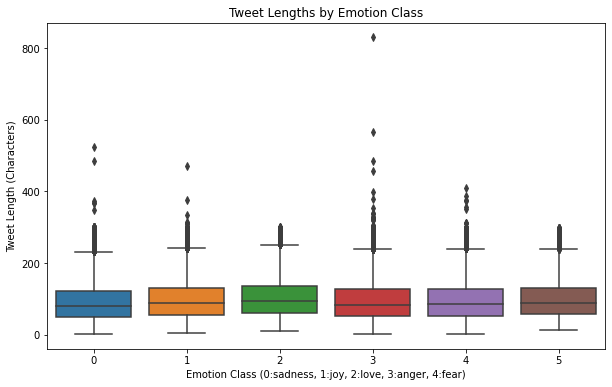

In [45]:
# Average tweet length for each emotion class
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Tweet Lengths by Emotion Class')
plt.xlabel('Emotion Class (0:sadness, 1:joy, 2:love, 3:anger, 4:fear)')
plt.ylabel('Tweet Length (Characters)')
plt.show()


**Comment:**  I noticed outliers here. These outliers represent tweets with lengths between 400-800 characters and distort the normal distribution. This situation could negatively impact the performance of our model, so I decided to go back to the data preprocessing stage and clean them using the IQR method.


Length changes after cleaning processes:
Original tweet length (average): 97.02839669968739
Length after basic cleaning (average): 97.02839669968739
Length after stopwords removal (average): 61.6915541650972
Length after lemmatization (average): 61.013423414561586

Word count changes after cleaning processes:
Original tweet word count (average): 19.211015117235952
Word count after basic cleaning (average): 19.211015117235952
Word count after stopwords removal (average): 9.35597839777932
Word count after lemmatization (average): 9.35597839777932


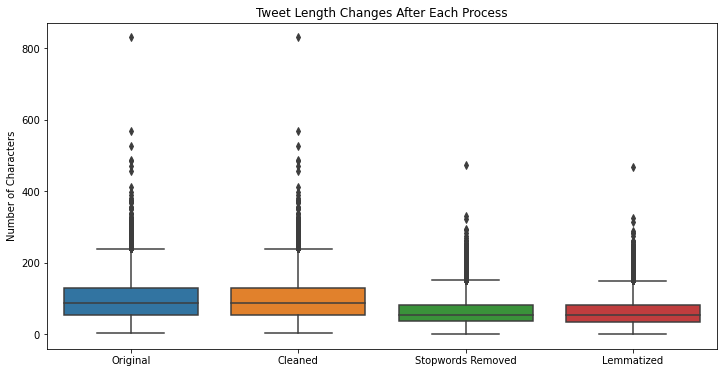

In [48]:
# Comparing original and cleaned tweet lengths
df_sample['original_length'] = df_sample['text'].apply(len)
df_sample['cleaned_length'] = df_sample['clean_text'].apply(len)
df_sample['stopwords_cleaned_length'] = df_sample['remove_stopwords'].apply(len)
df_sample['lemmatized_length'] = df_sample['lemmatized_text'].apply(len)

print("\nLength changes after cleaning processes:")
print("Original tweet length (average):", df_sample['original_length'].mean())
print("Length after basic cleaning (average):", df_sample['cleaned_length'].mean())
print("Length after stopwords removal (average):", df_sample['stopwords_cleaned_length'].mean())
print("Length after lemmatization (average):", df_sample['lemmatized_length'].mean())

# Comparing word counts
df_sample['original_word_count'] = df_sample['text'].apply(lambda x: len(str(x).split()))
df_sample['cleaned_word_count'] = df_sample['clean_text'].apply(lambda x: len(str(x).split()))
df_sample['stopwords_cleaned_word_count'] = df_sample['remove_stopwords'].apply(lambda x: len(str(x).split()))
df_sample['lemmatized_word_count'] = df_sample['lemmatized_text'].apply(lambda x: len(str(x).split()))

print("\nWord count changes after cleaning processes:")
print("Original tweet word count (average):", df_sample['original_word_count'].mean())
print("Word count after basic cleaning (average):", df_sample['cleaned_word_count'].mean())
print("Word count after stopwords removal (average):", df_sample['stopwords_cleaned_word_count'].mean())
print("Word count after lemmatization (average):", df_sample['lemmatized_word_count'].mean())

# Visualizing length changes
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sample[['original_length', 'cleaned_length', 'stopwords_cleaned_length', 'lemmatized_length']])
plt.title('Tweet Length Changes After Each Process')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Original', 'Cleaned', 'Stopwords Removed', 'Lemmatized'])
plt.show()


**Comment:** Looking at the data cleaning results, it can be seen that the basic cleaning process did not affect the tweet length (97.03 characters). However, after stopwords removal, the average length decreased by 36% to 61.69 characters, and the word count decreased by 51%, from 19.21 to 9.36. Lemmatization only reduced the text length by 1.1% (60.98 characters) and did not change the word count. These results suggest that the removal of stopwords significantly reduced the data size and allowed focusing on more meaningful features.

In [70]:
# Saving the processed dataset with its lemmatized version
output_df = df_sample[['lemmatized_text', 'label']]
output_df.columns = ['text', 'label'] 

print("\nFinal version of the processed data:")
print(output_df.head())

output_df.to_csv('twitter_emotions_preprocessed.csv', index=False)



Final version of the processed data:
                                                text  label
0         feel awful job get position succeed happen      0
1                                im alone feel awful      0
2  ive probably mentioned really feel proud actua...      1
3                        feeling little low day back      0
4  beleive much sensitive people feeling tend com...      2


# 4. Feature Extraction

In [71]:
df = pd.read_csv('twitter_emotions_preprocessed.csv')  # Processed dataset
df = df.dropna(subset=['text'])
print(f"Shape: {df.shape}")
print(f"First 5 rows:")
print(df.head())


Shape: (406831, 2)
First 5 rows:
                                                text  label
0         feel awful job get position succeed happen      0
1                                im alone feel awful      0
2  ive probably mentioned really feel proud actua...      1
3                        feeling little low day back      0
4  beleive much sensitive people feeling tend com...      2


In [72]:
# Function to tokenize words
def tokenize_text(text):
    """Splits the text into words"""
    return word_tokenize(str(text))

# Tokenizing all texts
df['tokens'] = df['text'].apply(tokenize_text)

print("\nTexts have been tokenized. Example:")
print(df['tokens'].head())

sample_size = len(df)  # Used the entire dataset
df_sample = df.sample(sample_size, random_state=42)



Texts have been tokenized. Example:
0    [feel, awful, job, get, position, succeed, hap...
1                             [im, alone, feel, awful]
2    [ive, probably, mentioned, really, feel, proud...
3                    [feeling, little, low, day, back]
4    [beleive, much, sensitive, people, feeling, te...
Name: tokens, dtype: object


In [73]:
# WORD2VEC EMBEDDING

word2vec_custom = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

# Save the trained model
word2vec_custom.save("models/word2vec_custom.model")

# Create text vectors using our own trained model
def get_custom_word2vec_features(tokens, model, vector_size=100):
    """Function to create vectors for our custom trained Word2Vec model"""
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Calculate custom Word2Vec vectors for all texts
print("Calculating custom Word2Vec features for the texts...")
X_word2vec_custom = np.array([get_custom_word2vec_features(tokens, word2vec_custom) 
                            for tokens in tqdm(df_sample['tokens'])])

print(f"Shape of our custom Word2Vec feature matrix: {X_word2vec_custom.shape}")

# Save the custom Word2Vec features
print("Saving our custom Word2Vec features...")
np.save('features/word2vec_custom_features.npy', X_word2vec_custom)


Calculating custom Word2Vec features for the texts...


100%|███████████████████████████████████████████████████████████████████████| 406831/406831 [00:08<00:00, 45613.69it/s]


Shape of our custom Word2Vec feature matrix: (406831, 100)
Saving our custom Word2Vec features...


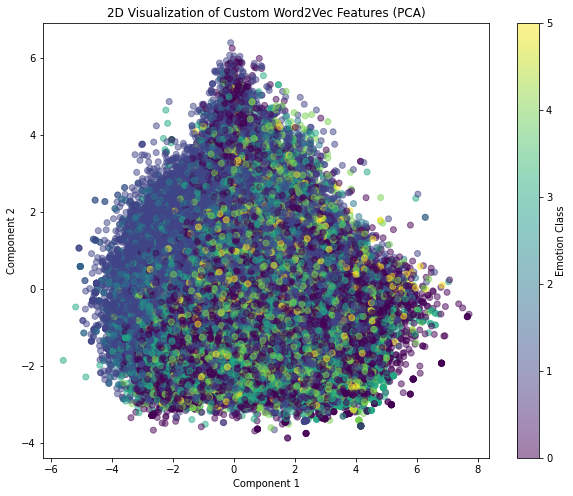

In [28]:
# Low-dimensional (2D) visualization for custom Word2Vec
pca = PCA(n_components=2, random_state=42)
X_word2vec_custom_2d = pca.fit_transform(X_word2vec_custom)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_word2vec_custom_2d[:, 0], X_word2vec_custom_2d[:, 1], 
                     c=df_sample['label'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Emotion Class')
plt.title('2D Visualization of Custom Word2Vec Features (PCA)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


**Comment:** This graph shows that words belonging to different emotional classes cluster in specific regions, but there is no complete separation between the classes. This suggests that the model has partially captured the emotional information.

In [145]:
np.save('features/labels.npy', df_sample['label'].values)

In [190]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  
    max_features=5500,  
    min_df=5,
    max_df=0.8
)
X_tfidf = vectorizer.fit_transform(df_sample['text'])

sp.save_npz('features/tfidf_features.npz', X_tfidf)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

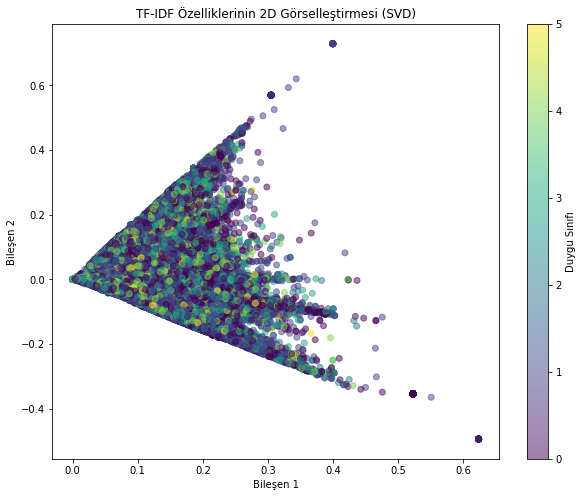

In [191]:
# Low-dimensional Visualization for TF-IDF
svd = TruncatedSVD(n_components=2, random_state=42)
X_tfidf_2d = svd.fit_transform(X_ngram_tfidf)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tfidf_2d[:, 0], X_tfidf_2d[:, 1], c=df_sample['label'], 
                     cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Sentiment Class')
plt.title('2D Visualization of TF-IDF Features (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

**Comment:** It can be observed that the points are densely clustered in the center and spread outward. However, the different sentiment classes are not clearly separated, and the classes are intertwined. This indicates that TF-IDF representations have limited success in distinguishing sentiment classes.

# 5. Data Balancing

In [148]:
# Undersampling for Word2Vec
# Load features and labels
X = np.load('features/word2vec_custom_features.npy')
y = np.load('features/labels.npy')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_counts = Counter(y_train)
min_class_count = min(class_counts.values())

# I have adjusted all classes to be sampled to the size of the smallest class.
sampling_strategy = {label: min_class_count for label in class_counts}

undersampler = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=42
)

X_balanced, y_balanced = undersampler.fit_resample(X_train, y_train)

print("Class distribution after undersampling::")
print(Counter(y_balanced))

np.save('balanced_features/word2vec_train_balanced.npy', X_balanced)
np.save('balanced_features/word2vec_y_train_balanced.npy', y_balanced)
np.save('balanced_features/word2vec_test.npy', X_test)
np.save('balanced_features/word2vec_y_test.npy', y_test)

Undersampling sonrası sınıf dağılımı:
Counter({0: 11673, 1: 11673, 2: 11673, 3: 11673, 4: 11673, 5: 11673})


In [192]:
# Undersampling for TF-IDF
from scipy.sparse import load_npz, save_npz
X = load_npz('features/ngram_tfidf_features.npz')
y = np.load('features/labels.npy')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_counts = Counter(y_train)
min_class_count = min(class_counts.values())

# I have adjusted all classes to be sampled to the size of the smallest class.
sampling_strategy = {label: min_class_count for label in class_counts}

undersampler = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=42
)

X_balanced, y_balanced = undersampler.fit_resample(X_train, y_train)

print("Class distribution after undersampling:")
print(Counter(y_balanced))

# Kaydet
save_npz('balanced_features/tfidf_train_balanced.npz', X_balanced)
np.save('balanced_features/tfidf_y_train_balanced.npy', y_balanced)
save_npz('balanced_features/tfidf_test.npz', X_test)
np.save('balanced_features/tfidf_y_test.npy', y_test)

Undersampling sonrası sınıf dağılımı:
Counter({0: 11673, 1: 11673, 2: 11673, 3: 11673, 4: 11673, 5: 11673})


In [103]:
# Undersampling for Transformer-based Models
df_sample = pd.read_csv('twitter_emotions_preprocessed.csv')
X = df_sample['text'].values.reshape(-1, 1)  # Raw texts for BERT
y = df_sample['label'].values

class_counts = Counter(y)
min_class_count = min(class_counts.values())

# I have adjusted all classes to be sampled to the size of the smallest class.
sampling_strategy = {label: min_class_count for label in class_counts}

undersampler = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=42
)

X_resampled, y_resampled = undersampler.fit_resample(X, y)

df_balanced_bert = pd.DataFrame({
    'text': X_resampled.flatten(),
    'label': y_resampled
})

print("Class distribution after undersampling:")
print(df_balanced_bert['label'].value_counts())

df_balanced_bert.to_csv('balanced_datasets/bert_text_balanced.csv', index=False)

Yeni sınıf dağılımı:
0    14592
1    14592
2    14592
3    14592
4    14592
5    14592
Name: label, dtype: int64


# 6. Modeling and Performance Evaluation

## 6.1 Baseline Models

In [3]:
X_train_word2vec = np.load('balanced_features/word2vec_train_balanced.npy')
y_train_word2vec = np.load('balanced_features/word2vec_y_train_balanced.npy')
X_test_word2vec = np.load('balanced_features/word2vec_test.npy')
y_test_word2vec = np.load('balanced_features/word2vec_y_test.npy')

X_train_, X_test_word2vec, y_train_, y_test_word2vec = train_test_split(
    X_test_word2vec, y_test_word2vec, test_size=0.2, random_state=42, stratify= y_test_word2vec
)

print(f"Training data shape: {X_train_word2vec.shape}")
print(f"Test data shape: {X_test_word2vec.shape}")

Training data shape: (70038, 100)
Test data shape: (16274, 100)


In [4]:
X_train_tfidf = load_npz('balanced_features/tfidf_train_balanced.npz')
y_train_tfidf = np.load('balanced_features/tfidf_y_train_balanced.npy')
X_test_tfidf = load_npz('balanced_features/tfidf_test.npz')
y_test_tfidf = np.load('balanced_features/tfidf_y_test.npy')

X_train_, X_test_tfidf, y_train_, y_test_tfidf = train_test_split(
    X_test_tfidf, y_test_tfidf, test_size=0.2, random_state=42, stratify= y_test_tfidf
)

print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")

Training data shape: (70038, 15000)
Test data shape: (16274, 15000)


In [5]:
emotion_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

### 6.1.1 Decision Tree

In [163]:
def train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test, param_distributions, n_iter=15, cv=5, random_state=42):
    dt_model = DecisionTreeClassifier()

    # RandomizedSearchCV
    random_search_dt = RandomizedSearchCV(
        estimator=dt_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )

    start_time = time.time()
    random_search_dt.fit(X_train, y_train)
    training_time = time.time() - start_time

    print(f"Training completed. Time: {training_time:.2f} seconds")
    print("Best Parameters:", random_search_dt.best_params_)
    print("Best Score:", random_search_dt.best_score_)

    best_model_dt = random_search_dt.best_estimator_

    y_train_pred = best_model_dt.predict(X_train)
    y_test_pred = best_model_dt.predict(X_test)

    print("\nAccuracy for Training Data:", accuracy_score(y_train, y_train_pred))
    print("F1 Score for Training Data:", f1_score(y_train, y_train_pred, average='weighted'))

    print("\nAccuracy for Test Data:", accuracy_score(y_test, y_test_pred))
    print("F1 Score for Test Data:", f1_score(y_test, y_test_pred, average='weighted'))

    print("\nClassification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))

    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))

    return best_model_dt, y_test, y_test_pred


In [195]:
param_distributions = {
    'max_depth': [3, 5, 7, 8, 10, None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 8, 10, 20, 30, 40],
    'min_samples_leaf': [1, 3, 5, 8, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2', None],
}

In [198]:
print("Decision Tree with TF-IDF\n")
best_model_tfidf, y_test_best_dt_tfidf, y_test_pred_best_dt_tfidf = train_and_evaluate_decision_tree(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, param_distributions)

print("\n****************************************************\n")

print("Decision Tree with Word2Vec\n")
best_model_word2vec, y_test_best_dt_word2vec, y_test_pred_best_dt_word2vec = train_and_evaluate_decision_tree(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, param_distributions)

Decision Tree with TF-IDF

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Training completed. Time: 35.91 seconds
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': None, 'criterion': 'log_loss'}
Best Score: 0.8929008827152061

Accuracy for Training Data: 0.9185299408892316
F1 Score for Training Data: 0.918036562460978

Accuracy for Test Data: 0.8715742902789726
F1 Score for Test Data: 0.8743496617135444

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92     11673
           1       0.93      0.86      0.90     11673
           2       0.90      0.97      0.94     11673
           3       0.92      0.93      0.93     11673
           4       0.92      0.87      0.90     11673
           5       0.89      0.98      0.93     11673

    accuracy                           0.92     70038
   macro avg       0.92      0.92      0.92     7003

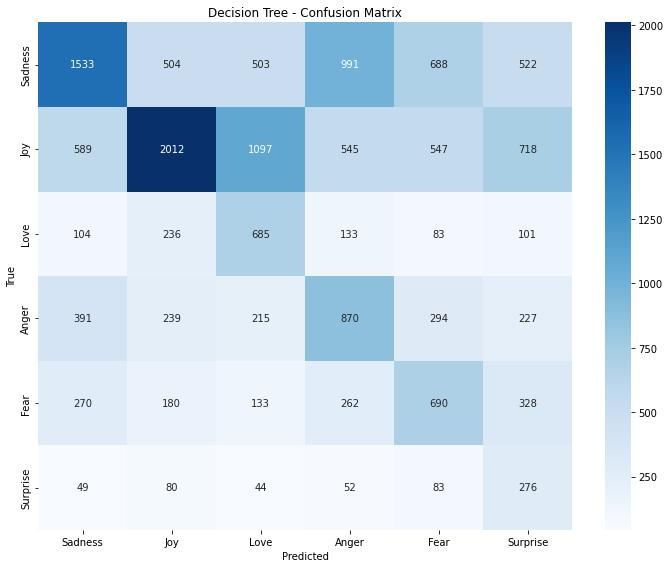

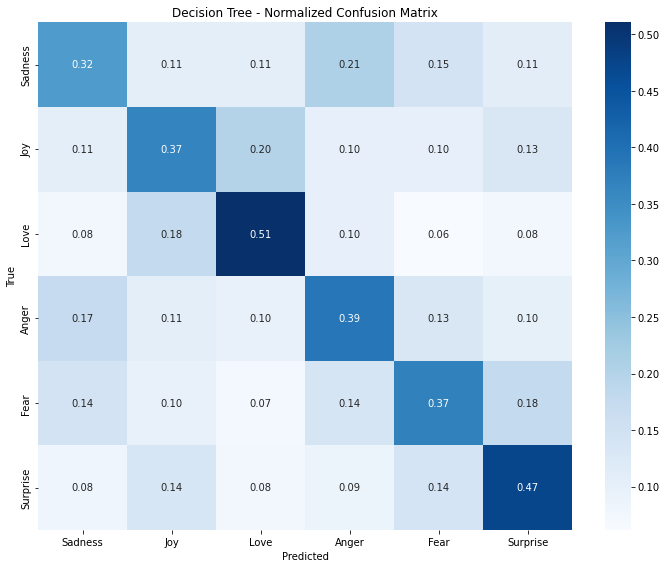

In [197]:
# Confusion Matrix of Decision Tree with TF-IDF
cm_log_reg = confusion_matrix(y_test_best_dt_tfidf, y_test_pred_best_dt_tfidf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree - Confusion Matrix')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm_log_reg = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_log_reg, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree - Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

### 6.1.2 Logistic Regression

In [168]:
def train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test, param_distributions, n_iter=15, cv=5, random_state=42):
    lr_model = LogisticRegression(max_iter=1000, random_state=random_state)
    
    # RandomizedSearchCV ile hiperparametre optimizasyonu
    random_search_lr = RandomizedSearchCV(
        estimator=lr_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search_lr.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"Training completed. Time: {training_time:.2f} seconds")
    print("Best Parameters:", random_search_lr.best_params_)
    print("Best Score:", random_search_lr.best_score_)
    
    best_model_lr = random_search_lr.best_estimator_
    
    y_train_pred = best_model_lr.predict(X_train)
    y_test_pred = best_model_lr.predict(X_test)
    
    print("\nAccuracy for Training Data:", accuracy_score(y_train, y_train_pred))
    print("F1 Score for Training Data:", f1_score(y_train, y_train_pred, average='weighted'))
    
    print("\nAccuracy for Test Data:", accuracy_score(y_test, y_test_pred))
    print("F1 Score for Test Data:", f1_score(y_test, y_test_pred, average='weighted'))
    
    print("\nClassification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))
    
    return best_model_lr, y_test, y_test_pred

In [199]:
param_distributions = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'class_weight': ['balanced', None]
}

In [34]:
print("Logistic Regression with TF-IDF\n")
# best_model_tfidf, y_test_best_lr_tfidf, y_test_pred_best_lr_tfidf = train_and_evaluate_logistic_regression(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, param_distributions)
# I ran it with random search, but I had to cancel it because it took too long.
# So I directly ran the model instead.

random_state = 42
lr_model = LogisticRegression(max_iter=1000, random_state=random_state)

# Modeli eğit
lr_model.fit(X_train_tfidf, y_train_tfidf)

y_train_pred_lr = lr_model.predict(X_train_tfidf)

# Test verisi üzerinde tahmin yap
y_test_pred_lr = lr_model.predict(X_test_tfidf)

    
print("\nAccuracy for Training Data:", accuracy_score(y_train_tfidf, y_train_pred_lr))
print("F1 Score for Training Data:", f1_score(y_train_tfidf, y_train_pred_lr, average='weighted'))
    
print("\nAccuracy for Test Data:", accuracy_score(y_test_tfidf, y_test_pred_lr))
print("F1 Score for Test Data:", f1_score(y_test_tfidf, y_test_pred_lr, average='weighted'))
    
print("\nClassification Report for Training Data:")
print(classification_report(y_train_tfidf, y_train_pred_lr))
    
print("\nClassification Report for Test Data:")
print(classification_report(y_test_tfidf, y_test_pred_lr))



Logistic Regression with TF-IDF


Accuracy for Training Data: 0.9503126873982695
F1 Score for Training Data: 0.9501401723790905

Accuracy for Test Data: 0.9097333169472779
F1 Score for Test Data: 0.9121142002817472

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11673
           1       0.97      0.91      0.94     11673
           2       0.93      0.99      0.96     11673
           3       0.96      0.97      0.97     11673
           4       0.96      0.90      0.93     11673
           5       0.91      0.99      0.95     11673

    accuracy                           0.95     70038
   macro avg       0.95      0.95      0.95     70038
weighted avg       0.95      0.95      0.95     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      4741
           1       0.97      0.88      0.92      5508

In [173]:
print("Logistic Regression with Word2Vec\n")
best_model_word2vec, y_test_best_lr_word2vec, y_test_pred_best_lr_word2vec = train_and_evaluate_logistic_regression(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, param_distributions)

Logistic Regression with Word2Vec

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Training completed. Time: 219.13 seconds
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 545.5594781168514}
Best Score: 0.669993521636832

Accuracy for Training Data: 0.6729061366686656
F1 Score for Training Data: 0.6723850166389663

Accuracy for Test Data: 0.6445864569251567
F1 Score for Test Data: 0.6600082246421038

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.65      0.60      0.63     11673
           1       0.66      0.66      0.66     11673
           2       0.68      0.71      0.69     11673
           3       0.66      0.66      0.66     11673
           4       0.69      0.67      0.68     11673
           5       0.70      0.73      0.72     11673

    accuracy                           0.67     70038
   macro avg       0.67      0.67      0.67     70038
weighted avg     

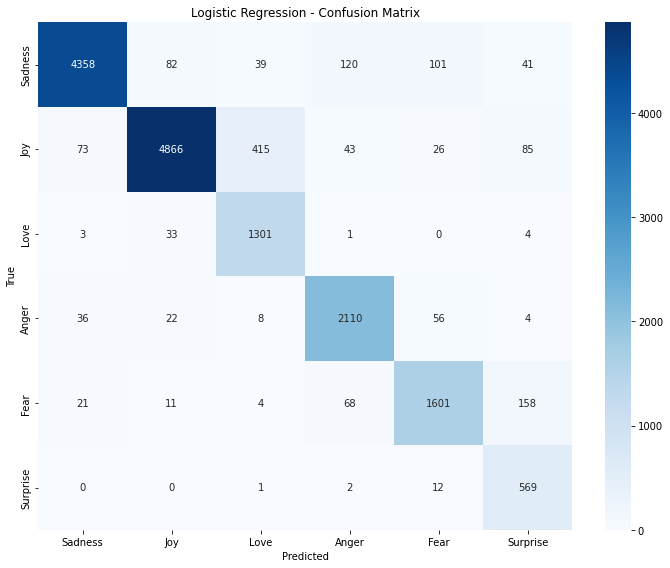

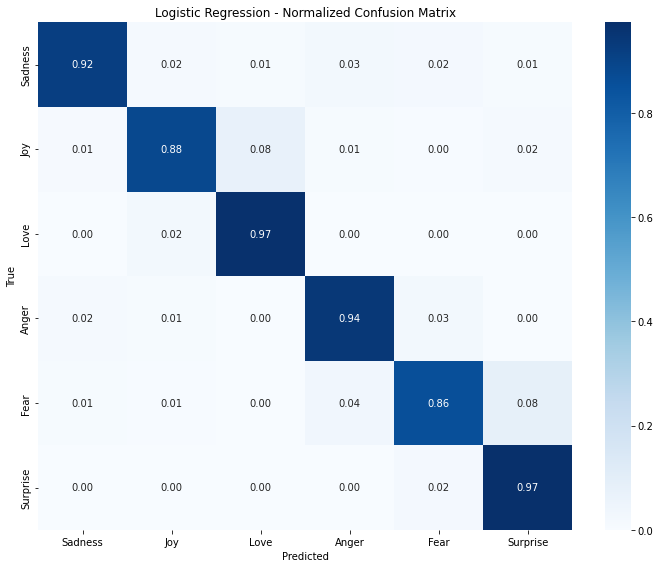

In [35]:
# Confusion Matrix
cm_log_reg = confusion_matrix(y_test_tfidf, y_test_pred_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression - Confusion Matrix')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm_log_reg = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_log_reg, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression - Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

### 6.1.3 Random Forest

In [36]:
def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, param_distributions, n_iter=10, cv=3, random_state=42):

    rf_model = RandomForestClassifier(random_state=random_state)
    
    # RandomizedSearchCV ile hiperparametre optimizasyonu
    random_search_rf = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search_rf.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"Training completed. Time: {training_time:.2f} seconds")
    print("Best Parameters:", random_search_rf.best_params_)
    print("Best Score:", random_search_rf.best_score_)
    
    best_model_rf = random_search_rf.best_estimator_
    
    y_train_pred = best_model_rf.predict(X_train)
    y_test_pred = best_model_rf.predict(X_test)
    
    print("\nAccuracy for Training Data:", accuracy_score(y_train, y_train_pred))
    print("F1 Score for Training Data:", f1_score(y_train, y_train_pred, average='weighted'))
    
    print("\nAccuracy for Test Data:", accuracy_score(y_test, y_test_pred))
    print("F1 Score for Test Data:", f1_score(y_test, y_test_pred, average='weighted'))
    
    print("\nClassification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))
    
    return best_model_rf, y_test, y_test_pred

In [37]:
param_distributions_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

In [38]:
print("Random Forest with TF-IDF\n")
best_model_rf_tfidf, y_test_best_rf_tfidf, y_test_pred_best_rf_tfidf = train_and_evaluate_random_forest(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, param_distributions_rf)

Random Forest with TF-IDF

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training completed. Time: 634.61 seconds
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
Best Score: 0.9289671321282733

Accuracy for Training Data: 0.941446072132271
F1 Score for Training Data: 0.9411993183580402

Accuracy for Test Data: 0.9125599115153005
F1 Score for Test Data: 0.9150453966231783

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11673
           1       0.97      0.89      0.93     11673
           2       0.92      0.99      0.95     11673
           3       0.95      0.95      0.95     11673
           4       0.94      0.89      0.91     11673
           5       0.90      0.99      0.95     11673

    accuracy                           0.94     70038
   macro avg  

In [78]:
print("Random Forest with Word2Vec\n")
# best_model_rf_word2vec, y_test_best_rf_word2vec, y_test_pred_best_rf_word2vec = train_and_evaluate_random_forest(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, param_distributions_rf)
# I ran it with Random Forest, but I had to cancel it because it took too long.
# So I directly ran the model instead.

rf_model = RandomForestClassifier(n_estimators=40, random_state=42)

rf_model.fit(X_train_word2vec, y_train_word2vec)

y_train_pred_rf = rf_model.predict(X_train_word2vec)
y_test_pred_rf = rf_model.predict(X_test_word2vec)

print("\nAccuracy for Training Data:", accuracy_score(y_train_word2vec, y_train_pred_rf))
print("F1 Score for Training Data:", f1_score(y_train_word2vec, y_train_pred_rf, average='weighted'))

print("\nAccuracy for Test Data:", accuracy_score(y_test_word2vec, y_test_pred_rf))
print("F1 Score for Test Data:", f1_score(y_test_word2vec, y_test_pred_rf, average='weighted'))

print("\nClassification Report for Training Data:")
print(classification_report(y_train_word2vec, y_train_pred_rf))

print("\nClassification Report for Test Data:")
print(classification_report(y_test_word2vec, y_test_pred_rf))


Random Forest with Word2Vec


Accuracy for Training Data: 0.9806390816413947
F1 Score for Training Data: 0.9806378107130395

Accuracy for Test Data: 0.5637827209045103
F1 Score for Test Data: 0.5803560285529584

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11673
           1       0.99      0.98      0.98     11673
           2       0.99      0.99      0.99     11673
           3       0.99      0.99      0.99     11673
           4       0.96      0.96      0.96     11673
           5       0.96      0.97      0.96     11673

    accuracy                           0.98     70038
   macro avg       0.98      0.98      0.98     70038
weighted avg       0.98      0.98      0.98     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.70      0.54      0.61      4741
           1       0.78      0.57      0.66      5508
   

In [79]:
# Confusion Matrix
cm_log_reg = confusion_matrix(y_test_best_rf_tfidf, y_test_pred_best_rf_tfidf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest - Confusion Matrix')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm_log_reg = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_log_reg, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest - Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

NameError: name 'y_test_best_rf_tfidf' is not defined

### 6.1.4 KNN

In [183]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, param_distributions, n_iter=15, cv=5, random_state=42):
    knn_model = KNeighborsClassifier()
    
    # RandomizedSearchCV ile hiperparametre optimizasyonu
    random_search_knn = RandomizedSearchCV(
        estimator=knn_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search_knn.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"Training completed. Time: {training_time:.2f} seconds")
    print("Best Parameters:", random_search_knn.best_params_)
    print("Best Score:", random_search_knn.best_score_)
    
    best_model_knn = random_search_knn.best_estimator_
    
    y_train_pred = best_model_knn.predict(X_train)
    y_test_pred = best_model_knn.predict(X_test)
    
    print("\nAccuracy for Training Data:", accuracy_score(y_train, y_train_pred))
    print("F1 Score for Training Data:", f1_score(y_train, y_train_pred, average='weighted'))
    
    print("\nAccuracy for Test Data:", accuracy_score(y_test, y_test_pred))
    print("F1 Score for Test Data:", f1_score(y_test, y_test_pred, average='weighted'))
    
    print("\nClassification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))
    
    return best_model_knn, y_test, y_test_pred

In [186]:
param_distributions_knn = {
    'n_neighbors': range(1,31), 
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'leaf_size': range(10,50,5),  
    'p': [1, 2]  
}

In [6]:
print("KNN with TF-IDF\n")
# best_model_knn_tfidf, y_test_best_knn_tfidf, y_test_pred_best_knn_tfidf = train_and_evaluate_knn(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, param_distributions_knn)
# I ran it with KNN, but I had to cancel it because it took too long.
# So I directly ran the model instead.

knn_model = KNeighborsClassifier(n_neighbors=9)

knn_model.fit(X_train_tfidf, y_train_tfidf)

y_train_pred_knn = knn_model.predict(X_train_tfidf)

y_test_pred_knn = knn_model.predict(X_test_tfidf)

print("\nAccuracy for Training Data:", accuracy_score(y_train_tfidf, y_train_pred_knn))
print("F1 Score for Training Data:", f1_score(y_train_tfidf, y_train_pred_knn, average='weighted'))

print("\nAccuracy for Test Data:", accuracy_score(y_test_tfidf, y_test_pred_knn))
print("F1 Score for Test Data:", f1_score(y_test_tfidf, y_test_pred_knn, average='weighted'))

print("\nClassification Report for Training Data:")
print(classification_report(y_train_tfidf, y_train_pred_knn))

print("\nClassification Report for Test Data:")
print(classification_report(y_test_tfidf, y_test_pred_knn))

KNN with TF-IDF


Accuracy for Training Data: 0.4846369113909592
F1 Score for Training Data: 0.5119415304705269

Accuracy for Test Data: 0.40242103969521936
F1 Score for Test Data: 0.4353548248254266

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.79      0.47      0.59     11673
           1       0.86      0.28      0.43     11673
           2       0.90      0.37      0.53     11673
           3       0.26      0.96      0.41     11673
           4       0.85      0.41      0.55     11673
           5       0.92      0.41      0.57     11673

    accuracy                           0.48     70038
   macro avg       0.76      0.48      0.51     70038
weighted avg       0.76      0.48      0.51     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.85      0.38      0.53      4741
           1       0.92      0.23      0.37      5508
           2  

In [188]:
print("KNN with Word2Vec\n")
best_model_knn_word2vec, y_test_best_knn_word2vec, y_test_pred_best_knn_word2vec = train_and_evaluate_knn(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, param_distributions_knn)

KNN with Word2Vec

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Training completed. Time: 3412.09 seconds
Best Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 27, 'leaf_size': 25, 'algorithm': 'auto'}
Best Score: 0.6130244129791187

Accuracy for Training Data: 0.6781175933064908
F1 Score for Training Data: 0.676035126983643

Accuracy for Test Data: 0.5776699029126213
F1 Score for Test Data: 0.5951728576403829

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.67      0.58      0.62     11673
           1       0.71      0.60      0.65     11673
           2       0.72      0.78      0.75     11673
           3       0.66      0.68      0.67     11673
           4       0.65      0.65      0.65     11673
           5       0.67      0.78      0.72     11673

    accuracy                           0.68     70038
   macro avg       0.68      0.68      0.68     70038
weighted avg       0.68      0.

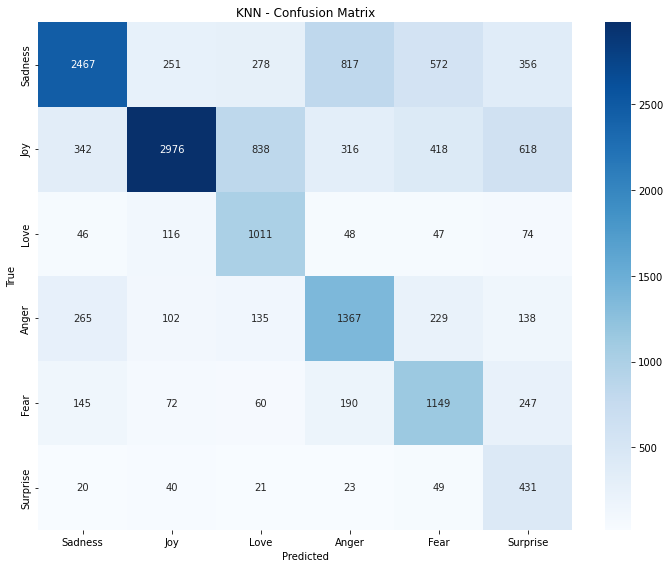

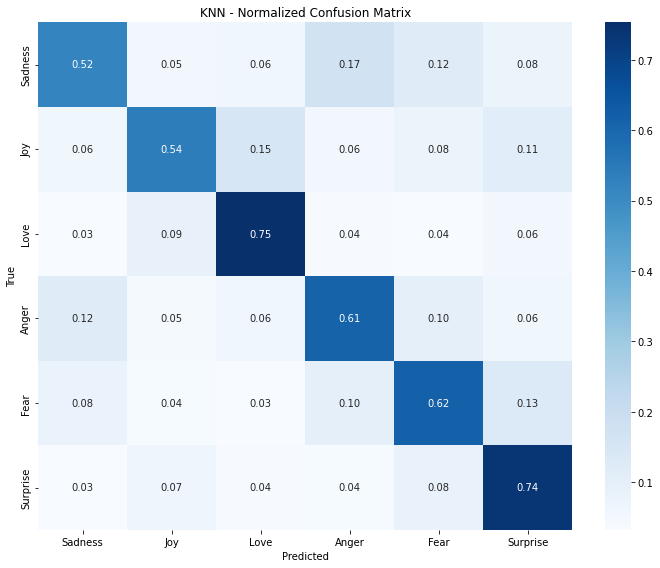

In [189]:
# Confusion Matrix
cm_log_reg = confusion_matrix(y_test_best_knn_word2vec, y_test_pred_best_knn_word2vec)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN - Confusion Matrix')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm_log_reg = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_log_reg, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN - Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

### 6.1.5 Naive Bayes

In [82]:
def train_and_evaluate_naive_bayes(X_train, y_train, X_test, y_test, param_distributions, n_iter=15, cv=5, random_state=42):
    nb_model = MultinomialNB()
    
    random_search_nb = RandomizedSearchCV(
        estimator=nb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search_nb.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"Training completed. Time: {training_time:.2f} seconds")
    print("Best Parameters:", random_search_nb.best_params_)
    print("Best Score:", random_search_nb.best_score_)
    
    best_model_nb = random_search_nb.best_estimator_
    
    y_train_pred = best_model_nb.predict(X_train)
    y_test_pred = best_model_nb.predict(X_test)
    
    print("\nAccuracy for Training Data:", accuracy_score(y_train, y_train_pred))
    print("F1 Score for Training Data:", f1_score(y_train, y_train_pred, average='weighted'))
    
    print("\nAccuracy for Test Data:", accuracy_score(y_test, y_test_pred))
    print("F1 Score for Test Data:", f1_score(y_test, y_test_pred, average='weighted'))
    
    print("\nClassification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))
    
    return best_model_nb, y_test, y_test_pred

In [83]:
param_distributions_nb = {
    'alpha': np.logspace(-3, 3, 20),  
    'fit_prior': [True, False] 
}

In [7]:
from sklearn.naive_bayes import MultinomialNB

In [8]:
print("MultinomialNB with TF-IDF\n")
# best_model_mnb_tfidf, y_test_best_mnb_tfidf, y_test_pred_best_mnb_tfidf = train_and_evaluate_naive_bayes(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, param_distributions_nb)
# I ran it with MultinomialNB, but I had to cancel it because it took too long.
# So I directly ran the model instead.

nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train_tfidf)

y_train_pred_nb = nb_model.predict(X_train_tfidf)

y_test_pred_nb = nb_model.predict(X_test_tfidf)

print("\nAccuracy for Training Data:", accuracy_score(y_train_tfidf, y_train_pred_nb))
print("F1 Score for Training Data:", f1_score(y_train_tfidf, y_train_pred_nb, average='weighted'))

print("\nAccuracy for Test Data:", accuracy_score(y_test_tfidf, y_test_pred_nb))
print("F1 Score for Test Data:", f1_score(y_test_tfidf, y_test_pred_nb, average='weighted'))

print("\nClassification Report for Training Data:")
print(classification_report(y_train_tfidf, y_train_pred_nb))

print("\nClassification Report for Test Data:")
print(classification_report(y_test_tfidf, y_test_pred_nb))

MultinomialNB with TF-IDF


Accuracy for Training Data: 0.9352351580570547
F1 Score for Training Data: 0.9350323916910815

Accuracy for Test Data: 0.887120560403097
F1 Score for Test Data: 0.8912876766769174

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     11673
           1       0.96      0.88      0.92     11673
           2       0.91      0.98      0.94     11673
           3       0.95      0.95      0.95     11673
           4       0.94      0.89      0.91     11673
           5       0.90      0.98      0.94     11673

    accuracy                           0.94     70038
   macro avg       0.94      0.94      0.94     70038
weighted avg       0.94      0.94      0.94     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4741
           1       0.97      0.85      0.91      5508
      

In [12]:
print("GaussianNB with Word2Vec\n")
# best_model_mnb_word2vec, y_test_best_mnb_word2vec, y_test_pred_best_mnb_word2vec = train_and_evaluate_naive_bayes(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, param_distributions_nb)
# I ran it with GaussianNB, but I had to cancel it because it took too long.
# So I directly ran the model instead.

nb_model = GaussianNB()

nb_model.fit(X_train_word2vec, y_train_word2vec)

y_train_pred_nb = nb_model.predict(X_train_word2vec)

y_test_pred_nb = nb_model.predict(X_test_word2vec)

print("\nAccuracy for Training Data:", accuracy_score(y_train_word2vec, y_train_pred_nb))
print("F1 Score for Training Data:", f1_score(y_train_word2vec, y_train_pred_nb, average='weighted'))

print("\nAccuracy for Test Data:", accuracy_score(y_test_word2vec, y_test_pred_nb))
print("F1 Score for Test Data:", f1_score(y_test_word2vec, y_test_pred_nb, average='weighted'))

print("\nClassification Report for Training Data:")
print(classification_report(y_train_word2vec, y_train_pred_nb))

print("\nClassification Report for Test Data:")
print(classification_report(y_test_word2vec, y_test_pred_nb))

GaussianNB with Word2Vec


Accuracy for Training Data: 0.5322824752277335
F1 Score for Training Data: 0.531298184831319

Accuracy for Test Data: 0.5159149563721274
F1 Score for Test Data: 0.5388074795578931

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.55      0.43      0.48     11673
           1       0.50      0.54      0.52     11673
           2       0.55      0.57      0.56     11673
           3       0.54      0.53      0.54     11673
           4       0.55      0.54      0.55     11673
           5       0.51      0.58      0.54     11673

    accuracy                           0.53     70038
   macro avg       0.53      0.53      0.53     70038
weighted avg       0.53      0.53      0.53     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.73      0.43      0.54      4741
           1       0.76      0.54      0.63      5508
       

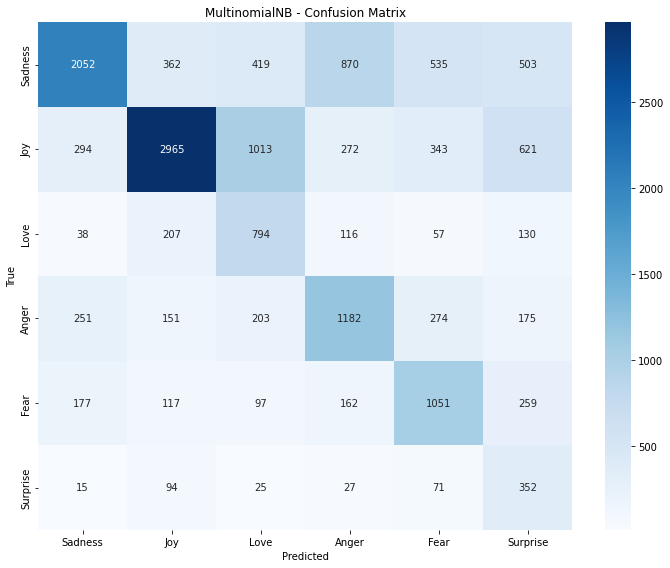

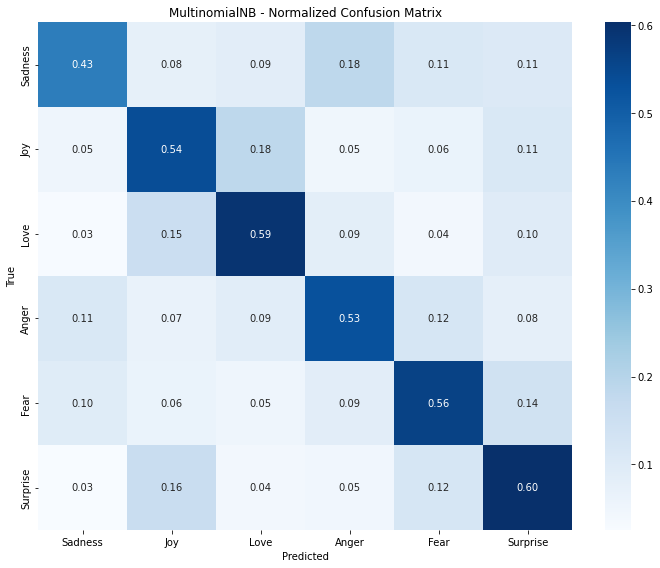

In [13]:
# Confusion Matrix
cm_log_reg = confusion_matrix(y_test_tfidf, y_test_pred_nb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MultinomialNB - Confusion Matrix')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm_log_reg = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_log_reg, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MultinomialNB - Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

### 6.1.6 XGBoost

In [14]:
def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test, param_distributions, n_iter=10, cv=3, random_state=42):
    xgb_model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
    
    # RandomizedSearchCV ile hiperparametre optimizasyonu
    random_search_xgb = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search_xgb.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"Training completed. Time: {training_time:.2f} seconds")
    print("Best Parameters:", random_search_xgb.best_params_)
    print("Best Score:", random_search_xgb.best_score_)
    
    best_model_xgb = random_search_xgb.best_estimator_
    
    y_train_pred = best_model_xgb.predict(X_train)
    y_test_pred = best_model_xgb.predict(X_test)
    
    print("\nAccuracy for Training Data:", accuracy_score(y_train, y_train_pred))
    print("F1 Score for Training Data:", f1_score(y_train, y_train_pred, average='weighted'))
    
    print("\nAccuracy for Test Data:", accuracy_score(y_test, y_test_pred))
    print("F1 Score for Test Data:", f1_score(y_test, y_test_pred, average='weighted'))
    
    print("\nClassification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))

In [15]:
param_distributions_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 0.5, 1, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 10],
}

In [16]:
print("XGBoost with TF-IDF\n")
# best_model_xgb_tfidf, y_test_best_xgb_tfidf, y_test_pred_best_xgb_tfidf = train_and_evaluate_xgboost(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, param_distributions_xgb)
# I ran it with XGBoost, but I had to cancel it because it took too long.
# So I directly ran the model instead.

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_model.fit(X_train_tfidf, y_train_tfidf)

y_train_pred_xgb = xgb_model.predict(X_train_tfidf)

y_test_pred_xgb = xgb_model.predict(X_test_tfidf)

print("\nAccuracy for Training Data:", accuracy_score(y_train_tfidf, y_train_pred_xgb))
print("F1 Score for Training Data:", f1_score(y_train_tfidf, y_train_pred_xgb, average='weighted'))

print("\nAccuracy for Test Data:", accuracy_score(y_test_tfidf, y_test_pred_xgb))
print("F1 Score for Test Data:", f1_score(y_test_tfidf, y_test_pred_xgb, average='weighted'))

print("\nClassification Report for Training Data:")
print(classification_report(y_train_tfidf, y_train_pred_xgb))

print("\nClassification Report for Test Data:")
print(classification_report(y_test_tfidf, y_test_pred_xgb))


XGBoost with TF-IDF


Accuracy for Training Data: 0.9349495987892287
F1 Score for Training Data: 0.9346707325219386

Accuracy for Test Data: 0.897259432223178
F1 Score for Test Data: 0.9000877809794506

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     11673
           1       0.92      0.90      0.91     11673
           2       0.92      0.99      0.96     11673
           3       0.96      0.93      0.94     11673
           4       0.94      0.89      0.91     11673
           5       0.90      1.00      0.94     11673

    accuracy                           0.93     70038
   macro avg       0.94      0.93      0.93     70038
weighted avg       0.94      0.93      0.93     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      4741
           1       0.94      0.88      0.91      5508
           2

In [18]:
print("XGBoost with Word2Vec\n")
# best_model_xgb_word2vec, y_test_best_xgb_word2vec, y_test_pred_best_xgb_word2vec = train_and_evaluate_xgboost(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, param_distributions_xgb)
# I ran it with XGBoost, but I had to cancel it because it took too long.
# So I directly ran the model instead.

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_model.fit(X_train_word2vec, y_train_word2vec)

y_train_pred_xgb = xgb_model.predict(X_train_word2vec)

y_test_pred_xgb = xgb_model.predict(X_test_word2vec)

print("\nAccuracy for Training Data:", accuracy_score(y_train_word2vec, y_train_pred_xgb))
print("F1 Score for Training Data:", f1_score(y_train_word2vec, y_train_pred_xgb, average='weighted'))

print("\nAccuracy for Test Data:", accuracy_score(y_test_word2vec, y_test_pred_xgb))
print("F1 Score for Test Data:", f1_score(y_test_word2vec, y_test_pred_xgb, average='weighted'))

print("\nClassification Report for Training Data:")
print(classification_report(y_train_word2vec, y_train_pred_xgb))

print("\nClassification Report for Test Data:")
print(classification_report(y_test_word2vec, y_test_pred_xgb))

XGBoost with Word2Vec


Accuracy for Training Data: 0.9117479082783632
F1 Score for Training Data: 0.911626231146494

Accuracy for Test Data: 0.6815165294334521
F1 Score for Test Data: 0.6930573378371584

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     11673
           1       0.93      0.90      0.91     11673
           2       0.92      0.95      0.93     11673
           3       0.92      0.92      0.92     11673
           4       0.90      0.87      0.88     11673
           5       0.89      0.93      0.91     11673

    accuracy                           0.91     70038
   macro avg       0.91      0.91      0.91     70038
weighted avg       0.91      0.91      0.91     70038


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      4741
           1       0.86      0.68      0.76      5508
          

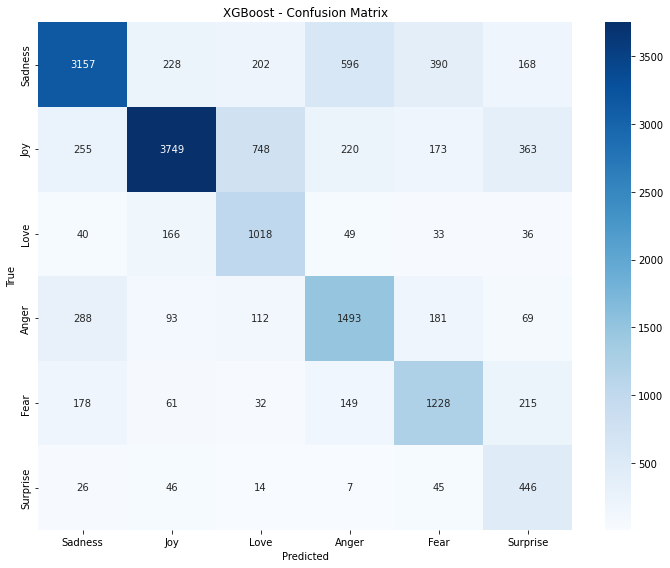

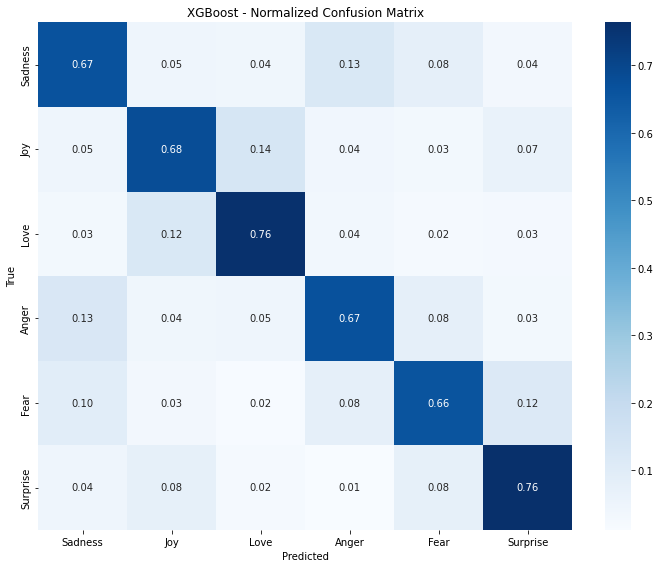

In [21]:
# Confusion Matrix
cm_log_reg = confusion_matrix(y_test_tfidf, y_test_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost - Confusion Matrix')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm_log_reg = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_log_reg, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[emotion_names[i] for i in range(6)],
            yticklabels=[emotion_names[i] for i in range(6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost - Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

## 6.2 Transformer-Based Models

### 6.2.1 BERT

Using device: cpu
Data loaded with shape: (87552, 2)
                                                text  label
0          able lose weight without feeling deprived      0
1                 feel terribly discontent job right      0
2  still feel stomach tightening even aching thou...      0
3                     feel rotten wild feral monster      0
4                               im feeling bad today      0

Class distribution:
0    14592
1    14592
2    14592
3    14592
4    14592
5    14592
Name: label, dtype: int64
Training set size: 70041
Test set size: 17511


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training started...

Epoch 1/2


Training: 100%|███████████████████████████████████████████████████████| 2189/2189 [1:13:36<00:00,  2.02s/it, loss=0.59]


Average training loss: 0.6523


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 548/548 [10:30<00:00,  1.15s/it]


Validation Accuracy: 0.9107
Validation F1 Score: 0.9101

Epoch 2/2


Training: 100%|███████████████████████████████████████████████████████| 2189/2189 [1:13:35<00:00,  2.02s/it, loss=0.59]


Average training loss: 0.2976


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 548/548 [07:58<00:00,  1.15it/s]


Validation Accuracy: 0.9267
Validation F1 Score: 0.9261

Training complete! Took 9940.78 seconds
Model saved to ./bert_model/
Evaluating model on test data...


Testing: 100%|███████████████████████████████████████████████████████████████████████| 548/548 [07:58<00:00,  1.15it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2918
           1       0.97      0.87      0.91      2918
           2       0.91      0.98      0.95      2919
           3       0.94      0.92      0.93      2919
           4       0.93      0.87      0.90      2919
           5       0.90      0.99      0.94      2918

    accuracy                           0.93     17511
   macro avg       0.93      0.93      0.93     17511
weighted avg       0.93      0.93      0.93     17511



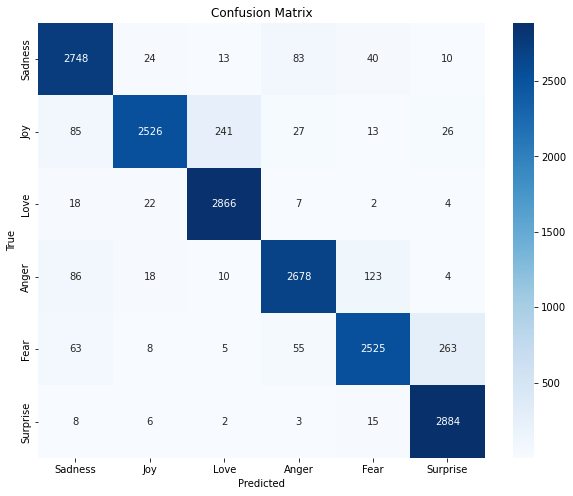

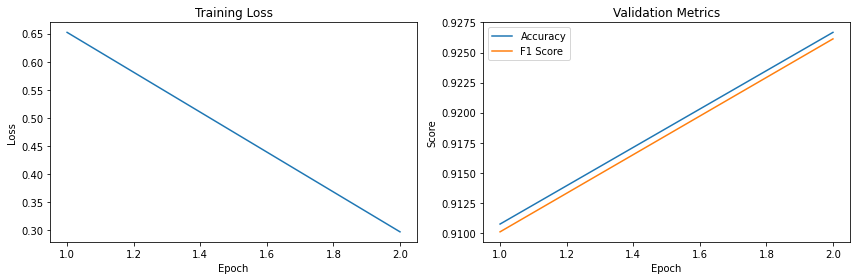

In [4]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Random seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

df = pd.read_csv('balanced_datasets/bert_text_balanced.csv')
print(f"Data loaded with shape: {df.shape}")

print(df.head())

print("\nClass distribution:")
print(df['label'].value_counts())

texts = df['text'].values
labels = df['label'].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {len(train_texts)}")
print(f"Test set size: {len(test_texts)}")

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TwitterEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):  # 128'den 64'e düşürüldü
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TwitterEmotionDataset(train_texts, train_labels, tokenizer)
test_dataset = TwitterEmotionDataset(test_texts, test_labels, tokenizer)

batch_size = 32  

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

num_labels = len(set(labels))

# BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

# Only fine-tune the last 4 layers, freeze the rest of the layers.
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for layer in model.bert.encoder.layer[:-4]:
    for param in layer.parameters():
        param.requires_grad = False

model.to(device)

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=3e-5,  
    eps=1e-8
)

epochs = 2

total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

accumulation_steps = 4

# Mixed precision
scaler = GradScaler()

def train_bert():
    print("Training started...")
    start_time = time.time()
    
    training_stats = []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        total_loss = 0
        
        model.train()
        
        progress_bar = tqdm(train_dataloader, desc='Training')
        
        optimizer.zero_grad()
        
        for step, batch in enumerate(progress_bar):
            # GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss / accumulation_steps
            
            scaler.scale(loss).backward()
            
            total_loss += loss.item() * accumulation_steps
            
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
            
            # Progress bar
            progress_bar.set_postfix({'loss': loss.item() * accumulation_steps})
        
        avg_train_loss = total_loss / len(train_dataloader)
        
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        model.eval()
        
        predictions = []
        true_labels = []
        
        for batch in tqdm(test_dataloader, desc='Evaluation'):
            # GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Gradient Calculation
            with torch.no_grad():
                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            
            logits = outputs.logits
            
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted'
        )
        
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")
        
        training_stats.append(
            {
                'epoch': epoch + 1,
                'training_loss': avg_train_loss,
                'valid_accuracy': accuracy,
                'valid_f1': f1,
                'precision': precision,
                'recall': recall
            }
        )
    
    training_time = time.time() - start_time
    print(f"\nTraining complete! Took {training_time:.2f} seconds")
    
    return model, training_stats

trained_model, stats = train_bert()

output_dir = './bert_model/'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

def evaluate_model(model, test_dataloader, device):
    print("Evaluating model on test data...")
    
    model.eval()
    
    predictions = []
    true_labels = []
    
    for batch in tqdm(test_dataloader, desc='Testing'):
        # GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Gradient Calculation
        with torch.no_grad():
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        
        logits = outputs.logits
        
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))
    
    cm = confusion_matrix(true_labels, predictions)
    
    emotions = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'][:num_labels]
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions,
                yticklabels=emotions)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('bert_confusion_matrix.png')
    plt.show()
    
    return predictions, true_labels

test_predictions, test_true_labels = evaluate_model(model, test_dataloader, device)

def plot_training_stats(stats):
    stats_df = pd.DataFrame(stats)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(stats_df['epoch'], stats_df['training_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(stats_df['epoch'], stats_df['valid_accuracy'], label='Accuracy')
    plt.plot(stats_df['epoch'], stats_df['valid_f1'], label='F1 Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('bert_training_stats.png')
    plt.show()

plot_training_stats(stats)
